In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
from tools import *
from methods import generalized_eig_extract, solve_scale_shift
import matplotlib.pyplot as plt
set_seaborn()

In [14]:
# set params
dim = 20
time = np.arange(0, 3, 0.05)
num_init = 20
init_var = 10 
iterations = np.arange(100)

a_s = np.array([3, 1.5, 0.6, 0.0175, 0.000001 ])
e_s = np.array([-5, -1.5, 0, 1.5, 5.001])

In [15]:
def learn_filter_from_inits(T_series, dim, shift=1):
    X0Xps = []
    X0X0s = []
    for i, t_series in enumerate(T_series):
        # build a series with some random initial conditons and noise
        han = build_hankel(t_series, dim)
        # compute coverances and avgerage
        X0 = han[:, :-shift]
        Xp = han[:, shift:]
        X0Xps.append(X0 @ Xp.T)
        X0X0s.append(X0 @ X0.T)
    # take means and compute top left eig vector 
    X0X0 = np.mean(X0X0s, axis=0)
    X0Xp = np.mean(X0Xps, axis=0)
    w, vl = scipy.linalg.eig(X0Xp, X0X0)
    sortorder = np.flip(np.argsort(w.real))
    w = w[sortorder]
    w = np.sort(np.real_if_close(w))[::-1]
    vl = vl[:, sortorder]
    theta = vl[:, 0]
    return theta
    

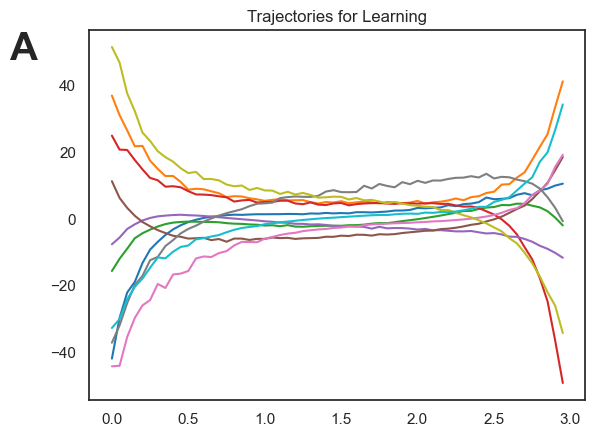

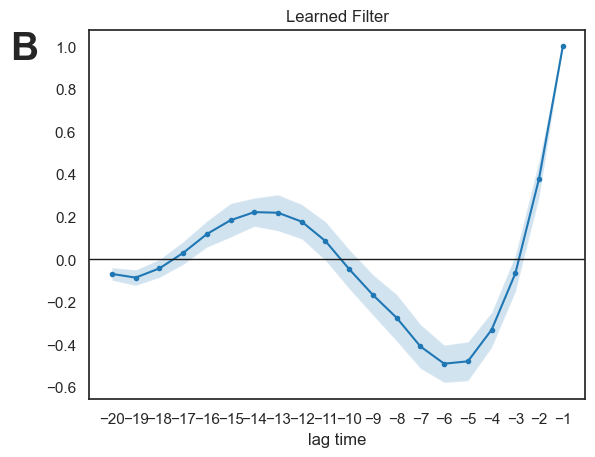

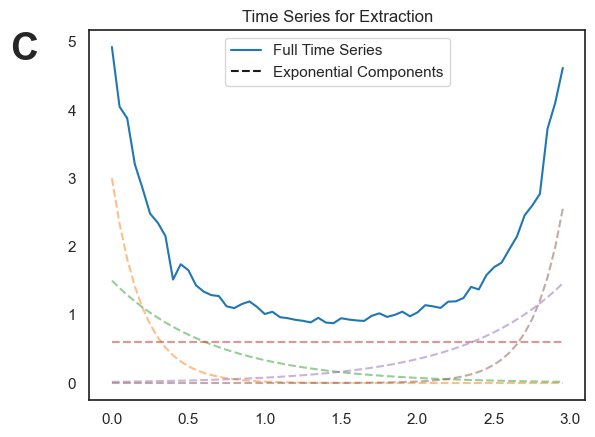

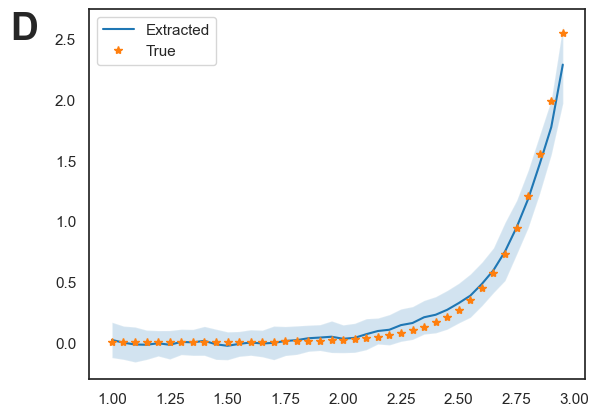

In [16]:
noise = 0.05
thetas = []
P_series_s = []
T_series_s = []
for itr in iterations:
    # build inital conditions by pertubing target inital conditions
    inits = np.tile(a_s, (num_init, 1)) 
    inits *= (1+init_var * np.random.randn(*inits.shape))

    # build training series with some random initial conditons and noise
    T_series = []
    for i,init in enumerate(inits):
        t_series, _, _, _ = build_exp_series(init, e_s, noise=noise, time=time)
        T_series.append(t_series)
        T_series_s.append(t_series)

    theta = learn_filter_from_inits(T_series, dim)

    # generate X_series and Y_series
    X_series, Y_series, _, components = build_exp_series(a_s, e_s, noise=noise, time=time)
    Y_series = Y_series[dim:]

    # ALGO
    Xhan = build_hankel(X_series, dim)

    P_series = theta.real @ Xhan
    P_series = solve_scale_shift(P_series, Y_series)

    theta /= theta[-1]

    thetas.append(theta.real)
    P_series_s.append(P_series)

# init cond plots
for t_series in T_series_s[:10]:
    plt.plot(time, t_series)
plt.title('Trajectories for Learning')
plt.text(-.16, .92, 'A', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

# filter plot
t_mean, t_std = np.mean(thetas, axis=0), np.std(thetas, axis=0)
lag_i = np.arange(-len(thetas[0]),0)
plt.xticks(lag_i)
plt.plot(lag_i, t_mean, '.-')
plt.fill_between(lag_i, t_mean-t_std, t_mean+t_std, alpha=0.2)
plt.xlabel('lag time')
plt.axhline(0, color="k", lw=1.0)
plt.title('Learned Filter')
plt.text(-.16, .92, 'B', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

# problem plot
plt.plot(time, X_series)
plt.plot([0], [0], '--', c='k') # dummy for legend
for c in components:
    plt.plot(time, c, '--', alpha=0.5)
plt.title('Time Series for Extraction')
plt.legend(['Full Time Series', 'Exponential Components'])
plt.text(-.16, .92, 'C', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

# solution plot
p_mean, p_std = np.mean(P_series_s, axis=0), np.std(P_series_s, axis=0)
p_time = time[dim:]
plt.plot(p_time, p_mean, '-', label='Extracted')
plt.fill_between(p_time, p_mean-p_std, p_mean+p_std, alpha=0.2)
plt.plot(p_time, Y_series, '*', label='True')
plt.legend()
plt.text(-.16, .92, 'D', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()




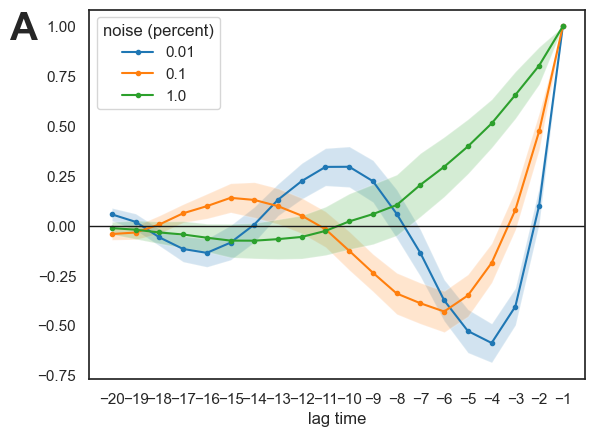

In [17]:
noises=[0.01, 0.1, 1.0]
for noise in noises:
    thetas = []
    P_series_s = []
    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        for i,init in enumerate(inits):
            t_series, _, _, _ = build_exp_series(init, e_s, noise=noise, time=time)
            T_series.append(t_series)

        theta = learn_filter_from_inits(T_series, dim)

        # generate X_series and Y_series
        X_series, Y_series, _, _ = build_exp_series(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]

        # ALGO
        Xhan = build_hankel(X_series, dim)

        P_series = theta.real @ Xhan
        P_series = solve_scale_shift(P_series, Y_series)

        theta /= theta[-1]

        thetas.append(theta.real)
        P_series_s.append(P_series)

    t_mean, t_std = np.mean(thetas, axis=0), np.std(thetas, axis=0)
    lag_i = np.arange(-len(thetas[0]),0)
    plt.xticks(lag_i)
    plt.plot(lag_i, t_mean, '.-', label=f'{noise}')
    plt.fill_between(lag_i, t_mean-t_std, t_mean+t_std, alpha=0.2)
    plt.xlabel('lag time')

plt.axhline(0, color="k", lw=1.0)
plt.legend(title='noise (percent)')
plt.text(-.16, .92, 'A', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()


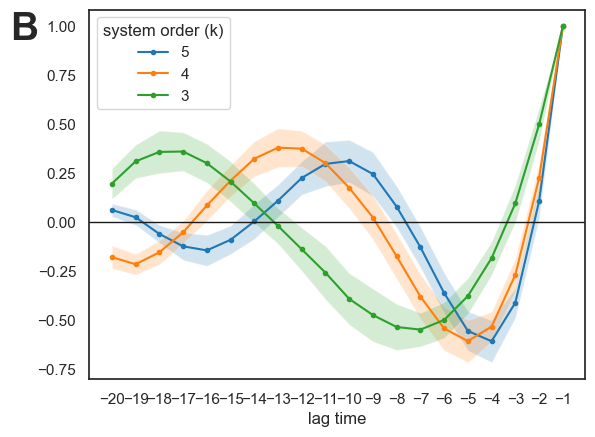

In [18]:
sysorders = [5, 4, 3]
noise = 0.01
for sysorder in sysorders:
    thetas = []
    P_series_s = []
    cur_a_s = a_s[-sysorder:]
    cur_e_s = e_s[-sysorder:]
    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(cur_a_s, (num_init, 1)) 
        inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        for i,init in enumerate(inits):
            t_series, _, _, _ = build_exp_series(init, cur_e_s, noise=noise, time=time)
            T_series.append(t_series)

        theta = learn_filter_from_inits(T_series, dim)

        # generate X_series and Y_series
        X_series, Y_series, _, _ = build_exp_series(cur_a_s, cur_e_s, noise=noise, time=time)
        Y_series = Y_series[dim:]

        # ALGO
        Xhan = build_hankel(X_series, dim)

        P_series = theta.real @ Xhan
        P_series = solve_scale_shift(P_series, Y_series)

        theta /= theta[-1]

        thetas.append(theta.real)
        P_series_s.append(P_series)

    t_mean, t_std = np.mean(thetas, axis=0), np.std(thetas, axis=0)
    lag_i = np.arange(-len(thetas[0]),0)
    plt.xticks(lag_i)
    plt.plot(lag_i, t_mean, '.-', label=f'{sysorder}')
    plt.fill_between(lag_i, t_mean-t_std, t_mean+t_std, alpha=0.2)
    plt.xlabel('lag time')

plt.axhline(0, color="k", lw=1.0)
plt.legend(title='system order (k)')
plt.text(-.16, .92, 'B', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()


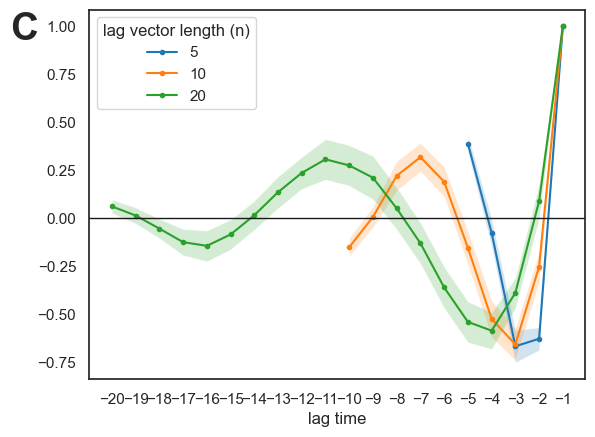

In [19]:
dims = [5, 10, 20]
noise = 0.01
for cur_dim in dims:
    thetas = []
    P_series_s = []
    for itr in iterations:
        # build inital conditions by pertubing target inital conditions
        inits = np.tile(a_s, (num_init, 1)) 
        inits *= (1+init_var * np.random.randn(*inits.shape))

        # build training series with some random initial conditons and noise
        T_series = []
        for i,init in enumerate(inits):
            t_series, _, _, _ = build_exp_series(init, e_s, noise=noise, time=time)
            T_series.append(t_series)

        theta = learn_filter_from_inits(T_series, cur_dim)

        # generate X_series and Y_series
        X_series, Y_series, _, _ = build_exp_series(a_s, e_s, noise=noise, time=time)
        Y_series = Y_series[cur_dim:]

        # ALGO
        Xhan = build_hankel(X_series, cur_dim)

        P_series = theta.real @ Xhan
        P_series = solve_scale_shift(P_series, Y_series)

        theta /= theta[-1]

        thetas.append(theta.real)
        P_series_s.append(P_series)

    t_mean, t_std = np.mean(thetas, axis=0), np.std(thetas, axis=0)
    lag_i = np.arange(-len(thetas[-1]),0)

    plt.plot(lag_i, t_mean, '.-', label=f'{cur_dim}')
    plt.fill_between(lag_i, t_mean-t_std, t_mean+t_std, alpha=0.2)
    plt.xlabel('lag time')

plt.xticks(lag_i)
plt.axhline(0, color="k", lw=1.0)
plt.legend(title='lag vector length (n)')
plt.text(-.16, .92, 'C', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

